In [185]:
# Helper libraries
import numpy as np
import pandas as pd
import cv2
import random as rn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# TensorFlow and tf.keras
import tensorflow as tf
from keras import backend as K
from keras import models
from keras.models import Sequential
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [186]:
# import warnings
# warnings.filterwarnings('always')
# warnings.filterwarnings('ignore')

# # data visualization and manipulation
# import matplotlib
# from matplotlib import style
# import seaborn as sns
# 

# import imageio

# # configures matplotlib to inline and will display graphs below the corresponding cell
# %matplotlib inline
# style.use('fivethirtyeight')
# sns.set(style='whitegrid', color_codes=True)

# #model selection
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import KFold
# from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import LabelEncoder

# #preprocess
# from keras.preprocessing.image import ImageDataGenerator

# #libraries


# #manipulation of zipped images and getting numpy arrays of pixel values of images

# # from tqdm import tqdm
# # from random import shuffle
# # from zipfile import ZipFile
# # from PIL import Image

# from image_handler import ImageHandler

In [187]:
# from skimage.transform import rescale, resize, rotate
# from skimage.color import rgb2gray
# from sklearn.metrics import confusion_matrix, auc, accuracy_score
# from sklearn.model_selection import train_test_split

# from keras.utils import np_utils
# from keras import callbacks
# from keras.models import load_model

In [188]:
IMG_DIR = '../datasets/annotated_honeybee/bee_imgs/'
data = pd.read_csv('../datasets/annotated_honeybee/bee_data.csv')
data.shape

(5172, 9)

In [189]:
health_counts = data["health"].value_counts()
target_categories = [name for name in health_counts.index if "varr" in name.lower() or "health" in name.lower()]
target_categories

['healthy', 'few varrao, hive beetles', 'Varroa, Small Hive Beetles']

In [190]:
data = data[[status in target_categories for status in data["health"]]]
data.head()
data.shape

(4435, 9)

In [191]:
data["has_varroa"] = (data["health"] != "healthy").astype(int)
# data["has_varroa"].head() # 0=healthy; 1=has_varroa
data.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,has_varroa
74,017_029.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker,0
75,017_015.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker,0
76,017_001.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker,0
77,017_000.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker,0
78,017_014.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker,0


In [192]:
data = data[["file","has_varroa"]]
data.head()

,file,has_varroa
74,017_029.png,0
75,017_015.png,0
76,017_001.png,0
77,017_000.png,0
78,017_014.png,0


In [193]:
data["has_varroa"].value_counts(normalize = True)

0    0.763021
1    0.236979
Name: has_varroa, dtype: float64

In [194]:
i = 0
for index, row in data.iterrows():
    if i == 2000:
        break
    if row['has_varroa'] == 0:
        data.drop(index ,axis=0, inplace=True)
        i += 1

data.shape

(2435, 2)

In [195]:
data["has_varroa"].value_counts(normalize = True)

0    0.568378
1    0.431622
Name: has_varroa, dtype: float64

In [196]:
data.shape

(2435, 2)

In [197]:
images = []
labels = []

IDEAL_WIDTH = 50
IDEAL_HEIGHT = 50

for index, row in data.iterrows():
    img = cv2.imread(f"{IMG_DIR}{row['file']}", cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IDEAL_WIDTH, IDEAL_HEIGHT))
    images.append(np.array(img))
    labels.append(row['has_varroa'])

In [198]:
images = np.array(images)
labels = np.array(labels)
images.shape

(2435, 50, 50, 3)

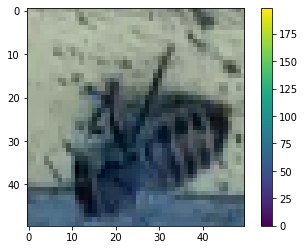

In [199]:
plt.figure()
plt.imshow(images[0])
plt.colorbar()
plt.grid(False)
plt.show()

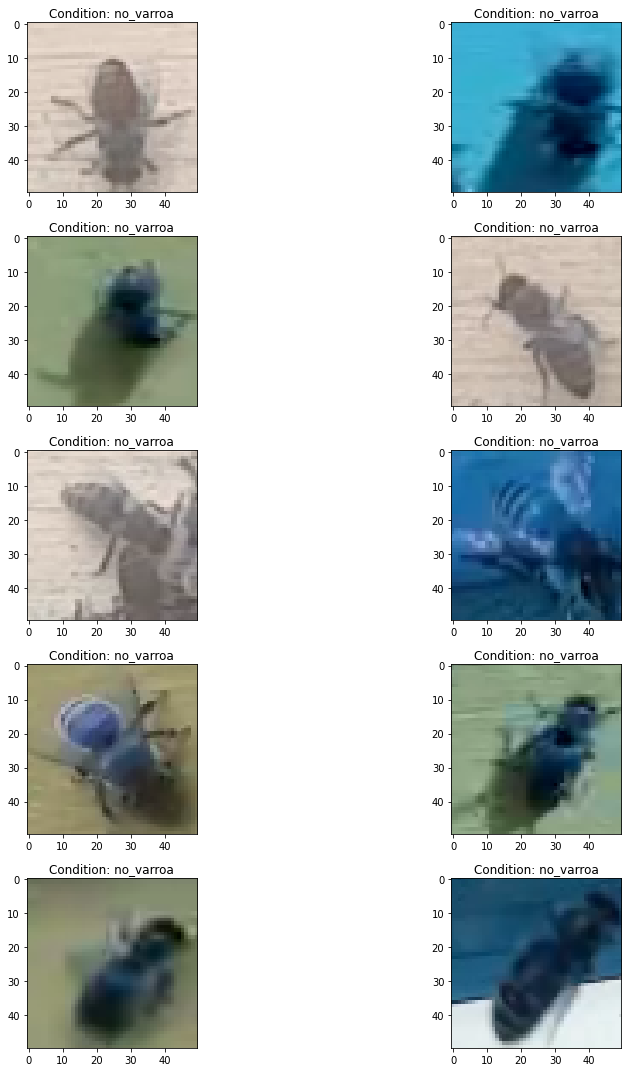

In [200]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l=rn.randint(0,len(labels))
        ax[i, j].imshow(images[l])
        label = 'has_varroa' if labels[l] == '1' else 'no_varroa'
        ax[i,j].set_title('Condition: '+ label)
plt.tight_layout()

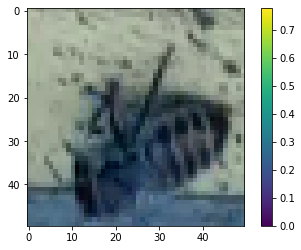

In [201]:
images = images / 255.0
plt.figure()
plt.imshow(images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [202]:
#splitting into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size = 0.05, random_state = 42)

In [203]:
train_images.shape

(2313, 50, 50, 3)

In [204]:
val_images.shape

(122, 50, 50, 3)

In [205]:
model = Sequential([
    Flatten(input_shape=(50, 50, 3)),
    Dense(128, activation='relu'),
    Dense(10)
])

In [206]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [207]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               320128    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 321,418
Trainable params: 321,418
Non-trainable params: 0
_________________________________________________________________


In [208]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10


ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:277 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer dense_2 is incompatible with the layer: expected axis -1 of input shape to have value 2500 but received input with shape [None, 7500]


In [13]:
def get_image_data(dir, files):
    return np.asanyarray([imageio.imread("{}{}".format(dir, file)) for file in files])

In [14]:
# raw_images = get_image_data(IMG_DIR, data["file"].values)

In [15]:
def show_image(image, ax = plt, title = None, show_size = False):
    ax.imshow(image)
    if title:
        ax.set_title(title)
    if not show_size:
        ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)

In [16]:
def show_images(files, titles = None, show_size = False):
    cols = 4
    f, ax = plt.subplots(nrows=int(np.ceil(len(files)/cols)),ncols=cols, figsize=(14,5))
    ax = ax.flatten()
    for i, file in enumerate(files):
        if titles:
            show_image(file, ax = ax[i], title = titles[i], show_size = show_size)
        else:
            show_image(file, ax = ax[i], title = None, show_size = show_size)
    plt.show()

In [17]:
# show_image(raw_images[0])
# show_images(raw_images[::1200], list(data["has_varroa"].map({1: "has_varroa", 0: "healthy"})[::1200]))

In [18]:
# resizing = (IDEAL_WIDTH, IDEAL_HEIGHT, 3)
# resized_images = ImageHandler(raw_images).resize(resizing)

In [19]:
# show_images(resized_images.images_for_display[::1200], list(data["has_varroa"].map({1: "has_varroa", 0: "healthy"})[::1200]))

In [20]:
def make_train_data(data, DIR):
    for index, row in data.iterrows():
        path = os.path.join(DIR, row['file'])
        label = str(row['has_varroa'])
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IDEAL_WIDTH, IDEAL_HEIGHT))
        X.append(np.array(img))
        Z.append(label)
        
#     for img in tqdm(os.listdir(DIR)):
#         label = assign_label(img, bee_type)
#         path = os.path.join(DIR, img)
#         ext = img[-4:]
#         if (ext != '.jpg'):
#             continue
#         img = cv2.imread(path, cv2.IMREAD_COLOR)
#         img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
#         X.append(np.array(img))
#         Z.append(str(label))

In [21]:
make_train_data(data, IMG_DIR)
print(len(X))

4435


In [22]:
# Gaussian Blur
# def blur():
#     for i in range(1, len(X)):
#         X[i] = cv2.GaussianBlur(X[i], (5, 5), 0) 

# Preprocessing
# for i in range(len(X)):
#     # Gaussian Blur
#     im = X[i]
#     im = cv2.GaussianBlur(im, (5, 5), 0)
#     X[i] = im
    
# Not using the preprocessing below because they don't mark the bees very well
#     # Image Segmentation
#     gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
#     ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
#     # Further noise removal
#     kernel = np.ones((3, 3), np.uint8)
#     opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
#     # sure background area
#     sure_bg = cv2.dilate(opening, kernel, iterations=3)
#     # Finding sure foreground area
#     dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
#     ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
#     # Finding unknown region
#     sure_fg = np.uint8(sure_fg)
#     unknown = cv2.subtract(sure_bg, sure_fg)

#     # Marker labelling
#     ret, markers = cv2.connectedComponents(sure_fg)
#     # Add one to all labels so that sure background is not 0, but 1
#     markers = markers + 1
#     # Now, mark the region of unknown with zero
#     markers[unknown == 255] = 0
    
#     markers = cv2.watershed(im, markers)
#     im[markers == -1] = [255, 0, 0]
#     markers = cv2.watershed(X[i], markers)
#     X[i] = im

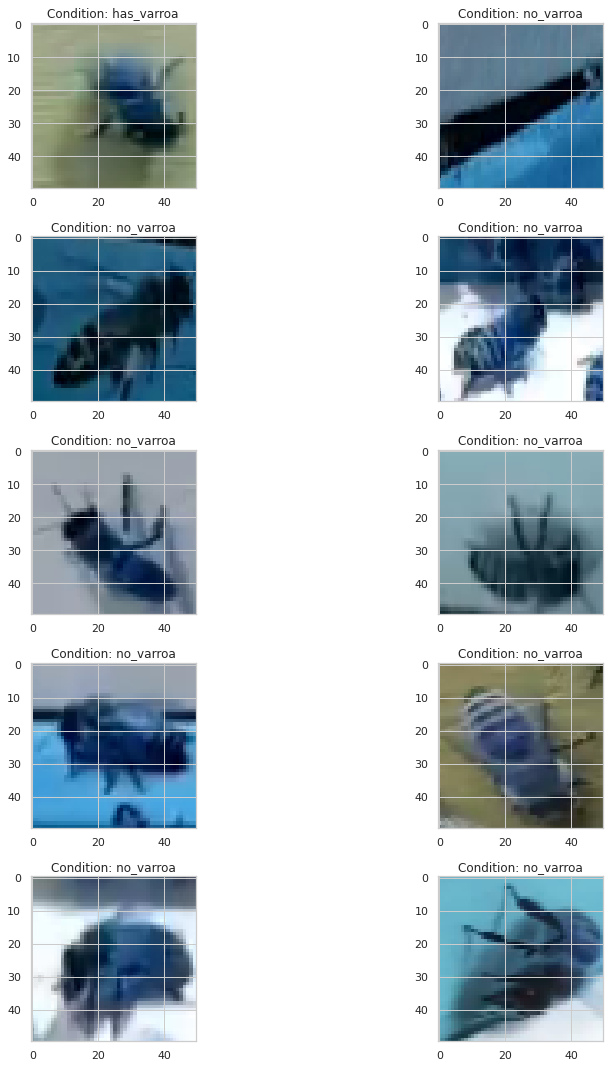

In [24]:
# label encoding
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
X=np.array(X)
X=X/255

In [26]:
#inputting the random seeds
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [27]:
params = {
    "conv__filters_1" : 32,
    "conv__filters_2" : 48,
    "conv__filters_3" : 64,
    "density_units_1" : 256,
    "density_units_2" : 64,
    "batch_size"      : 64,
    "epochs"          : 50
}

kernel_size = 3
dropout = .5
activation_func = "relu"
input_shape = (IDEAL_WIDTH,IDEAL_HEIGHT,3)

conv__filters_1 = params.get('conv__filters_1') or 32
conv__filters_2 = params.get('conv__filters_2') or 16
conv__filters_3 = params.get('conv__filters_3') or 32
density_units_1 = params.get('density_units_1') or 32
density_units_2 = params.get('density_units_2') or 32
epochs          = params.get('epochs') or 8

In [28]:
# Using CNN to start modelling

# model = Sequential()
# model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
# #model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
# #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dense(2, activation = "softmax"))

model = Sequential([
        # Conv layer #1
        Conv2D(
            filters = conv__filters_1, 
            kernel_size = kernel_size + 4, 
            activation  = activation_func, 
            input_shape = input_shape, #input layer
            padding     = "same"
        ),
        Conv2D(filters = conv__filters_1, kernel_size = kernel_size + 4, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Conv layer #2
        Conv2D(filters = conv__filters_2, kernel_size = kernel_size + 2, activation=activation_func, padding = "same"),
        Conv2D(filters = conv__filters_2, kernel_size = kernel_size + 2, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Conv layer #3
        Conv2D(filters = conv__filters_3, kernel_size = kernel_size, activation=activation_func, padding = "same"),
        Conv2D(filters = conv__filters_3, kernel_size = kernel_size, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Dense layer #1
        Flatten(),
        Dense(density_units_1, activation=activation_func),
        Dropout(dropout),
        
        # Dense layer #2
        Dense(density_units_2, activation=activation_func),
        Dropout(dropout),
        
        # Output layer
        Dense(2, activation = "softmax")
    ])

In [29]:
# Using a LR Annealer

batch_size = 54 # 128
epochs = 50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [30]:
# data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [31]:
# x_test

In [32]:
# compiling the model & summary
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        4736      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        50208     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 48)        38448     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 48)        57648     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 48)        0

In [33]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage

In [34]:
# fitting training set and making predictions on the validation set

History = model.fit(x_train, y_train, epochs=50)

# History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (x_test,y_test),
#                               verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-34-d1de46598553>:3) ]] [Op:__inference_train_function_1521]

Function call stack:
train_function


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

print('\nTest accuracy:', test_acc)

In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(x_test)

In [ ]:
predictions[0]

In [ ]:
np.argmax(predictions[0])

In [ ]:
class_names = ['No Varroa', 'With Varroa']

In [ ]:
class_names[np.argmax(predictions[0])]

In [ ]:
class_names[np.argmax(predictions[1])]

In [ ]:
i = 0
for row in data.iterrows():
    print(i)
    i += 1
    print(row)
#     if row['has_varroa'] == 1:
#         print(row)
# data = data[["file","has_varroa"]]
# data

In [ ]:
class_names[np.argmax(predictions[1021])]

In [ ]:
# graph for model accuracy between training and validation
# plt.plot(History.history['accuracy'])
# plt.plot(History.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epochs')
# plt.legend(['test', 'train'])
# plt.show()

In [ ]:
# print(x_test)
# predictions = model.predict(x_test)
# print(predictions)
# print(predictions[0])

In [ ]:
# class_names = ['No Varroa', 'With Varroa']

# def plot_image(i, predictions_array, true_label, img):
#   true_label, img = true_label[i], img[i]
#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])

#   plt.imshow(img, cmap=plt.cm.binary)

#   predicted_label = np.argmax(predictions_array)
#   if predicted_label == true_label:
#     color = 'blue'
#   else:
#     color = 'red'

#   plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
#                                 100*np.max(predictions_array),
#                                 class_names[true_label]),
#                                 color=color)

# def plot_value_array(i, predictions_array, true_label):
#   true_label = true_label[i]
#   plt.grid(False)
#   plt.xticks(range(7))
#   plt.yticks([])
#   thisplot = plt.bar(range(7), predictions_array, color="#777777")
#   plt.ylim([0, 1])
#   predicted_label = np.argmax(predictions_array)

#   thisplot[predicted_label].set_color('red')
#   thisplot[true_label].set_color('blue')

In [ ]:
# y_ = [np.argmax(y_test, axis=None, out=None) for y in y_test]
# for i in range(100):
#     plt.figure(figsize=(6,3))
#     plt.subplot(1,2,1)
#     plot_image(i, predictions[i], y_, x_test)
#     plt.subplot(1,2,2)
#     plot_value_array(i, predictions[i], y_)
#     #plt.show()
# plt.tight_layout()

In [ ]:
# export model
model_path = "../varroa_det_model_v1"
model.save(model_path)

In [ ]:
# load model
from tensorflow import keras
loaded_model = keras.models.load_model(model_path)

In [ ]:
# verify that the exported model works properly
prediction_by_model = model.predict(x)
prediction_by_loaded_model = loaded_model.predict(x_test)

In [ ]:
print(prediction_by_model[0])
print(prediction_by_loaded_model[0])

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

def classify(img_path, saved_model, class_names):
    # Preprocess image
    IMG_SIZE = 150
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = img.astype("float") / 255.0
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    
    prediction = saved_model.predict(img_batch)
    # print(prediction)
    print(class_names[np.argmax(prediction)] + '(' + str(round(100*np.max(prediction), 2)) + '%)')

In [ ]:
classify('../annotated-honeybee-dataset/bee_imgs/021_235.png', loaded_model, class_names)

In [ ]:
classify('../annotated-honeybee-dataset/bee_imgs/038_042.png', loaded_model, class_names)

In [ ]:
predictions = model.predict(x_test)
predictions

In [ ]:
classify('../test_dataset/honeybee_with_varroa/001_001.jpeg', loaded_model, class_names)

In [ ]:
classify('../test_dataset/honeybee_with_varroa/001_002.jpg', loaded_model, class_names)

In [ ]:
classify('../test_dataset/honeybee_with_varroa/001_003.png', loaded_model, class_names)

In [ ]:
classify('../test_dataset/honeybee_without_varroa/001_001.jpeg', loaded_model, class_names)

In [ ]:
classify('../test_dataset/honeybee_without_varroa/001_002.jpg', loaded_model, class_names)

In [ ]:
classify('../test_dataset/honeybee_without_varroa/001_003.jpeg', loaded_model, class_names)

In [ ]:
classify('../bee_test/001_005.jpg', loaded_model, class_names)

In [ ]:
classify('../bee_test/001_006.jpg', loaded_model, class_names)

In [ ]:
classify('../bee_test/001_007.png', loaded_model, class_names)

In [ ]:
classify('../bee_test/001_008.jpg', loaded_model, class_names)

In [ ]:
classify('../bee_test/001_009.jpg', loaded_model, class_names)